<a href="https://colab.research.google.com/github/Sanyam8055/100-Days-of-ML/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()




Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse



Using TensorFlow backend.


In [0]:
def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    generator = Model([inputs, labels], x, name='generator')
    return generator


def build_discriminator(inputs, labels, image_size):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator


In [0]:
def train(models, data, params):
    # the GAN models
    generator, discriminator, adversarial = models
    # images and labels
    x_train, y_train = data
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # one-hot label the noise will be conditioned to
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    # number of elements in train dataset
    train_size = x_train.shape[0]

    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_class, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # corresponding one-hot labels of real images
        real_labels = y_train[rand_indexes]
        # generate fake images from noise using generator
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]

        # generate fake images conditioned on fake labels
        fake_images = generator.predict([noise, fake_labels])    # See here where we give labels to the generator
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # real + fake one-hot labels = 1 batch of train one-hot labels
        labels = np.concatenate((real_labels, fake_labels))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images conditioned on fake 1-hot labels w/ label=1.0
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution        
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                           batch_size)]
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        if (i%100==0):
          print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False

            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=show,
                        step=(i + 1),
                        model_name=model_name)
    
    # save the model after training the generator
    # the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")

In [0]:
def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

In [0]:
def build_and_train_models():
    # load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels],
                        outputs,
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)


def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label

    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")
    




11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          8624        class_labels[0][0]               
__________________________________________________________________________________________________
discriminator_input (InputLayer (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.692914, acc: 0.328125] [adversarial loss: 0.883521, acc: 0.000000]
100: [discriminator loss: 0.000007, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
200: [discriminator loss: 0.000141, acc: 1.000000] [adversarial loss: 0.000002, acc: 1.000000]
300: [discriminator loss: 0.000390, acc: 1.000000] [adversarial loss: 0.025624, acc: 1.000000]
400: [discriminator loss: 0.038829, acc: 0.992188] [adversarial loss: 0.107280, acc: 1.000000]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
500: [discriminator loss: 0.112821, acc: 0.968750] [adversarial loss: 0.004433, acc: 1.000000]
600: [discriminator loss: 0.042966, acc: 0.992188] [adversarial loss: 0.238850, acc: 0.890625]
700: [discriminator loss: 0.556109, acc: 0.757812] [adversarial loss: 0.054985, acc: 1.000000]
800: [discriminator loss: 0.544015, acc: 0.648438] [adversarial loss: 0.566733, acc: 0.625000]
900: [discriminator loss: 0.672252, acc: 0.578125] [adversarial loss: 1

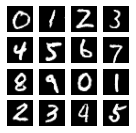

In [7]:

build_and_train_models()